Christopher McCoy,
Kevin Vincent,
Jason Lomsdalen,
Andrew LeDawson,
Conor Whatley

# Classifying iFixit Users: Browsing or Repairing?

We collected data from iFixit's website for about 24 hours in order to answer the question: which users are browsing the site, and which are actively engaged in a repair?

To collect our data, a script was run on iFixit's website that generated new data every 5 seconds a user was browsing the site.  Over the course of 24 hours, this generated about 43.62 GB of data.  We pre-processed this data in order to create a single data point for each session.  A session represents a single user browsing a single web page.  If that user navigates to a separate page on iFixit's site, that is a new session.

After 24 minutes and 38 seconds of pre-processing, we were left with 31.6 MB of data representing 140,834 unique sessions.

Let's import this data, clean it up a bit, and take a look at it to see if we can classify users into two categories: browsing and repairing.

# Importing the Data

Let's import the data and see how it looks in it's original form.

In [74]:
%matplotlib inline
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

#Load dataset
data = pd.read_json("outputSplit.txt", lines=True)
data.head()

,cgp,cts,fdt,ldt,nd,pg,sid,sts-md,sts-mn,thc-md,thc-mn
0,0.0,0.0,1.552026e+12,1.552028e+12,72,/Guide/iPhone+6s+LCD+and+Digitizer+Replacement...,cjsznskfw00003feb7uj4xkpq,0.0,0.000000,0.0,0.000000
1,0.0,0.0,1.552025e+12,1.552030e+12,3777,/Guide/Details+for++iPhone+7+PCB+Diagram/67315,cjszfhxwv00001ue6vjye28mz,382.0,382.000000,0.0,0.000000
2,0.0,0.0,1.552026e+12,1.552033e+12,3758,/Teardown/Dell+XPS+13+Teardown/36157,cjszh8ph9000026e65loxhols,0.0,0.000000,0.0,0.000000
3,0.0,7.0,1.552026e+12,1.552037e+12,2795,/Teardown/iPad+Pro+11-Inch+Teardown/115457,cjszmn8vc00003mdyqmntbqto,20.0,508.944444,1.0,1.042553
4,0.0,1.0,1.552026e+12,1.552042e+12,4251,/Teardown/Bose+QuietComfort+35+PARTIAL+Teardow...,cjszl6yih00003ae2ilfj9ske,7.0,23.000000,0.0,1.933333


It's hard to tell what's going on here.  Let's clean things up.

# Cleaning the Data

First, let's rename the columns to make them more readable.  While we're at it, let's define what each column means/represents.
 - **Gave Points**: The user clicked the "give the author points" button at the bottom of the page
 - **Comments Time**: The amount of time (in seconds) the user spent viewing the comments section of the page
 - **First Time**: The time data started being collected from this session
 - **Last Time**: The last time data was collected from this session
 - **Data Number**: The number of times data was collected during this session
 - **Page Title**: The web page title/url
 - **Session ID**: A unique ID used to represent/identify each session
 - **Median Step Time**: The median amount of time the user spent looking at the steps
 - **Mean Step Time**: The mean (average) amount of time the user spent looking at each step
 - **Median Hover Time**: The median amount of time the user spent hovering their mouse over the images on the page
 - **Mean Hover Time**: The mean (average) amount of time the user spent hovering their mouse over the images on the page

Then, we will filter out bad data.  We define bad data as sessions where the mean or median time spent on each step was less than 5 seconds, when the mean step time was over 1,000 seconds, or when the time spent reading comments was over 5,000 seconds.

This takes our data from about 141,000 data points to about 27,000.

In [76]:
# Rename the columns to be more readable
data.columns = ["Gave Points", "Comments Time", "First Time", "Last Time", "Data Number", "Page Title", "Session ID", "Median Step Time", "Mean Step Time", "Median Hover Time", "Mean Hover Time"]

#Keep only entries with mean step times between 0 and 5,000
clean_data = data[(data['Mean Step Time'] > 5) & (data['Mean Step Time'] < 1000)]
clean_data = clean_data[(clean_data['Comments Time'] < 5000)]
clean_data = clean_data[(clean_data['Median Step Time'] > 5)]

#Shape of the data before
print(data.shape)

#Shape of the data after cleaning
print(clean_data.shape)
clean_data.head()

(140834, 11)
(26910, 11)


,Gave Points,Comments Time,First Time,Last Time,Data Number,Page Title,Session ID,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time
1,0.0,0.0,1.552025e+12,1.552030e+12,3777,/Guide/Details+for++iPhone+7+PCB+Diagram/67315,cjszfhxwv00001ue6vjye28mz,382.0,382.000000,0.0,0.000000
3,0.0,7.0,1.552026e+12,1.552037e+12,2795,/Teardown/iPad+Pro+11-Inch+Teardown/115457,cjszmn8vc00003mdyqmntbqto,20.0,508.944444,1.0,1.042553
4,0.0,1.0,1.552026e+12,1.552042e+12,4251,/Teardown/Bose+QuietComfort+35+PARTIAL+Teardow...,cjszl6yih00003ae2ilfj9ske,7.0,23.000000,0.0,1.933333
14,0.0,1.0,1.552026e+12,1.552031e+12,1348,/Guide/Olympus+Stylus+1030+SW+Camera+Lens+Repl...,cjszn01b200003bdyhc858142,281.0,253.333333,5.0,5.709677
17,0.0,26.0,1.552026e+12,1.552031e+12,2829,/Guide/Sony+Xperia+Z5+Battery+Replacement/85104,cjszinxq900003bdyb9dw4sny,23.0,24.000000,3.0,3.300000


Some columns were useful when pre-processing the data, but aren't useful to us when analyzing data trends.  These columns represent when data was collected, for how long, which page they were collected on, and the ID associated with each session.  The only one of these columns which may be of interest to us is the page title, but since we are trying to classify the data as a whole and not per page, we can remove it for the time being.  Let's delete these columns:
 - First Time
 - Last Time
 - Data Number
 - Page Title
 - Session ID

Here is what the data looks like with these columns removed.

In [101]:
simplified_data = clean_data.drop(columns = ['First Time', 'Last Time', 'Data Number', 'Page Title', 'Session ID'])
simplified_data.head()

,Gave Points,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time
1,0.0,0.0,382.0,382.000000,0.0,0.000000
3,0.0,7.0,20.0,508.944444,1.0,1.042553
4,0.0,1.0,7.0,23.000000,0.0,1.933333
14,0.0,1.0,281.0,253.333333,5.0,5.709677
17,0.0,26.0,23.0,24.000000,3.0,3.300000


Things are looking better.  Let's round some of these numbers to make them more readable.

In [102]:
simplified_data = round(simplified_data, 3)
simplified_data.head()

,Gave Points,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time
1,0.0,0.0,382.0,382.000,0.0,0.000
3,0.0,7.0,20.0,508.944,1.0,1.043
4,0.0,1.0,7.0,23.000,0.0,1.933
14,0.0,1.0,281.0,253.333,5.0,5.710
17,0.0,26.0,23.0,24.000,3.0,3.300


Much better.  Now let's take a look at the data.

# Visualizing the data

Let's start with a scatter plot matrix comparing all of our variables.

### Scatter Plot Matrix

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

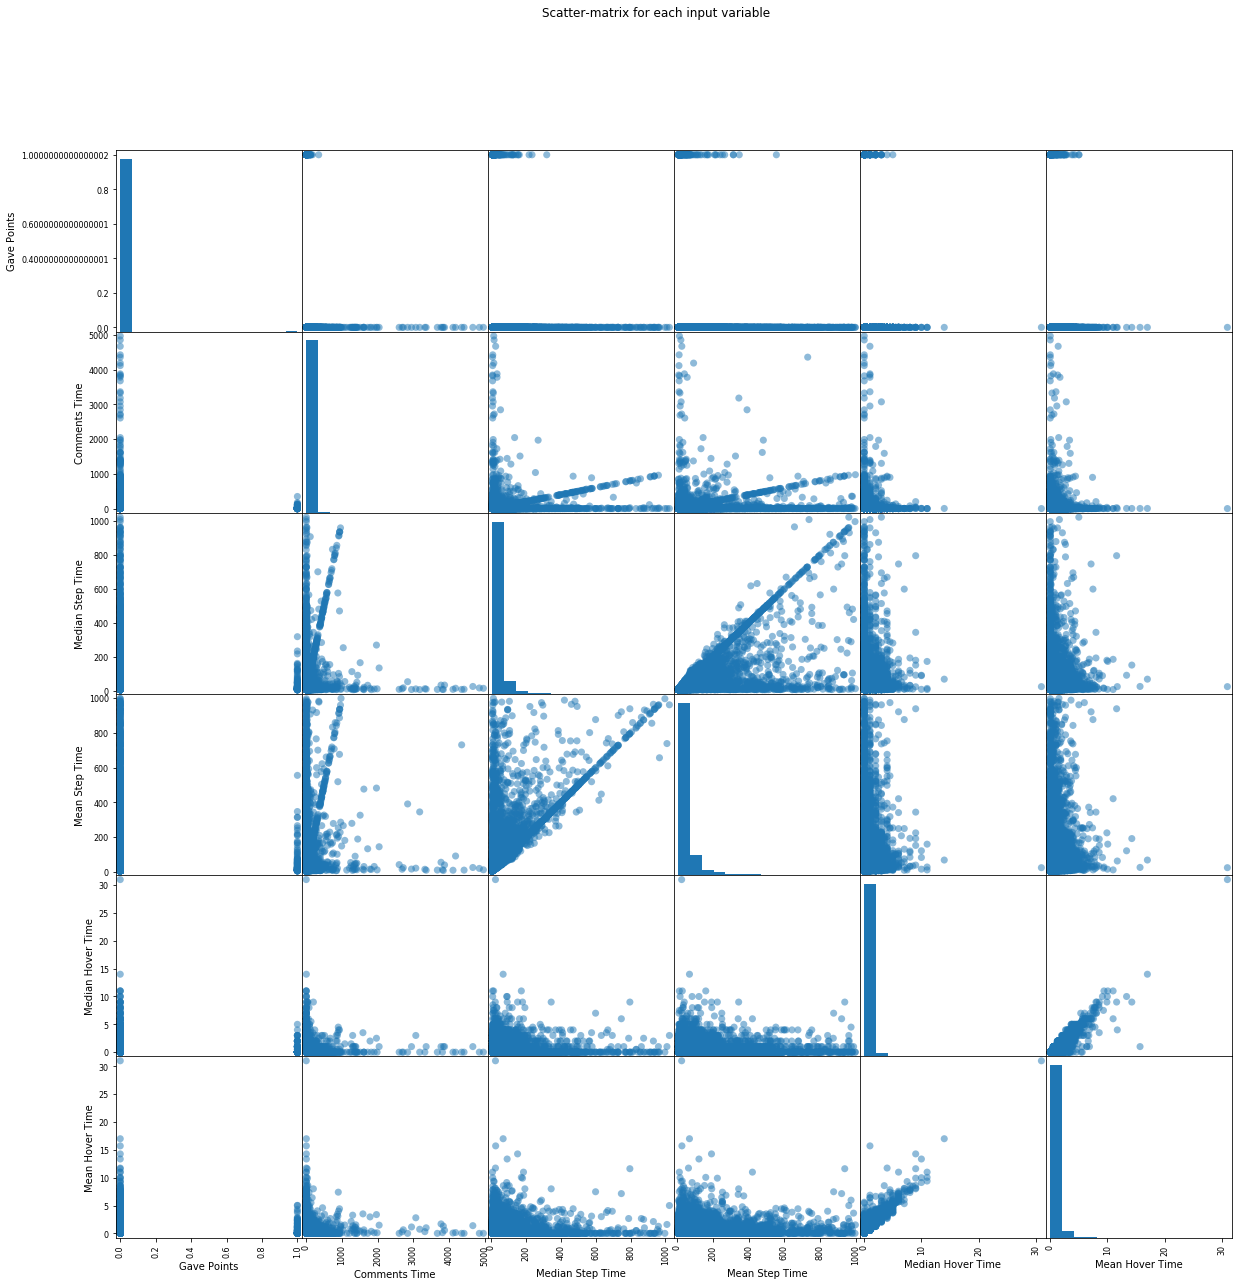

In [103]:
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
feature_names = ['Gave Points', 'Comments Time', 'Median Step Time', 'Mean Step Time', 'Median Hover Time', 'Mean Hover Time']
X = simplified_data[feature_names]
scatter = pd.plotting.scatter_matrix(X, marker = 'o', s=50, hist_kwds={'bins':15}, figsize=(20,20))
plt.suptitle('Scatter-matrix for each input variable')

There are a few things to notice right away when looking at this scatter plot matrix.  First of all, there is an almost perfectly straight, diagonal line in some of the plots.  It looks like this line exists when comparing the mean and median step time and when comparing the 'comments time' to either the mean or median step time.  This seems quite strange.  What we expect to see is a relationship more similar to the one we see between the mean and median hover time, where the two variables are related but the relationship does not form a perfect line.  Unfortunately, we aren't quite sure what could have caused this.

The second thing we notice is that there are large amounts of data concentrated around 0 for each variable.  This makes sense, because we assume most users are probably just browsing the site, so they don't spend too much time on the page.

We can also see that the mean and median step/hover times look very similar.

#### To make things a bit simpler, let's just compare four variables: 
 - Whether the user clicked the "Give this author points" button
 - The amount of time the user spent reading comments
 - The mean time spent on each step
 - The mean time spent hovering over each thumbnail

Text(0.5, 0.98, 'Scatter-matrix on four variables')

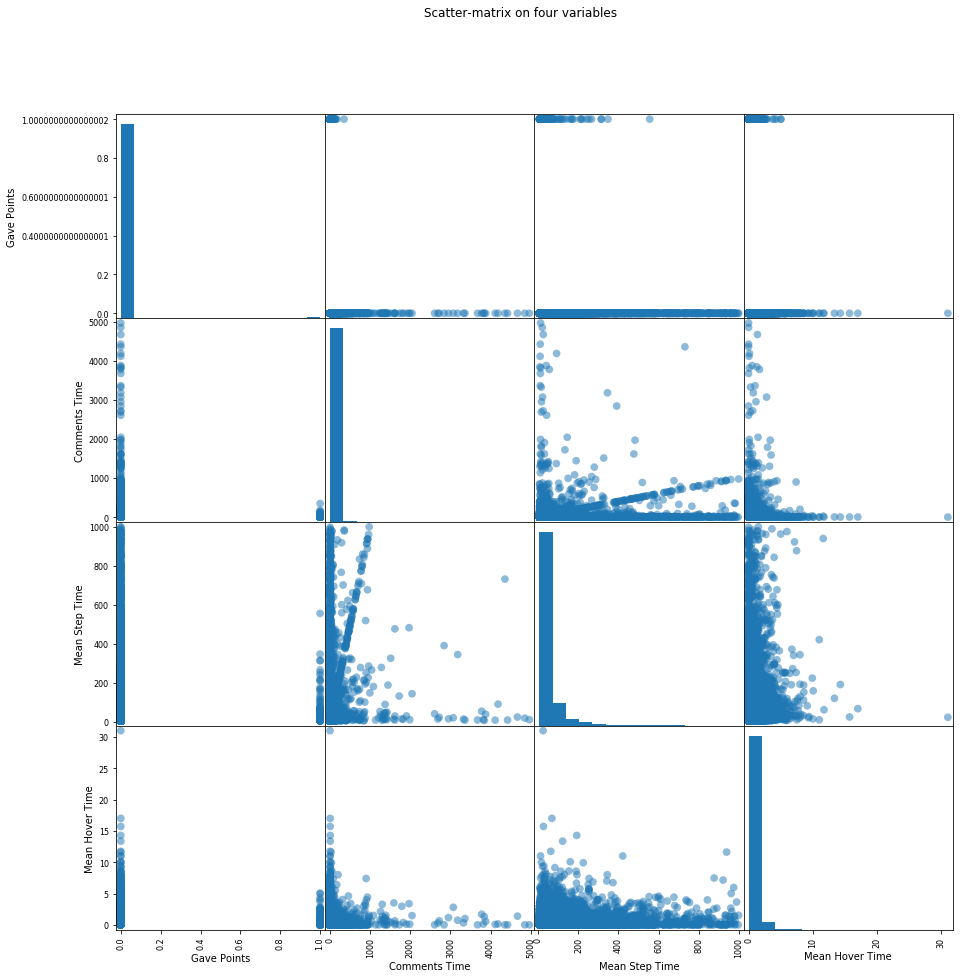

In [104]:
feature_names = ['Gave Points', 'Comments Time', 'Mean Step Time', 'Mean Hover Time']
X = simplified_data[feature_names]
scatter = pd.plotting.scatter_matrix(X, marker = 'o', s=60, hist_kwds={'bins':15}, figsize=(15,15))
plt.suptitle('Scatter-matrix on four variables')

Unfortunately, there aren't many obvious trends in the data with the exception of the strangely linear relationship between 'Comments Time' and 'Mean Step Time'.

The one thing we may be able to conclude is that users who spend a long time on a single page are unlikely to click the 'give this author points' button.

### Scatter Plot

Let's take a look at a scatter plot of some of the data.  We will put the mean step time along the x-axis and the mean hover time along the y-axis.  We chose to compare these two variables because they are the two which we initially expected to be the best indicators of whether users are browsing or repairing.

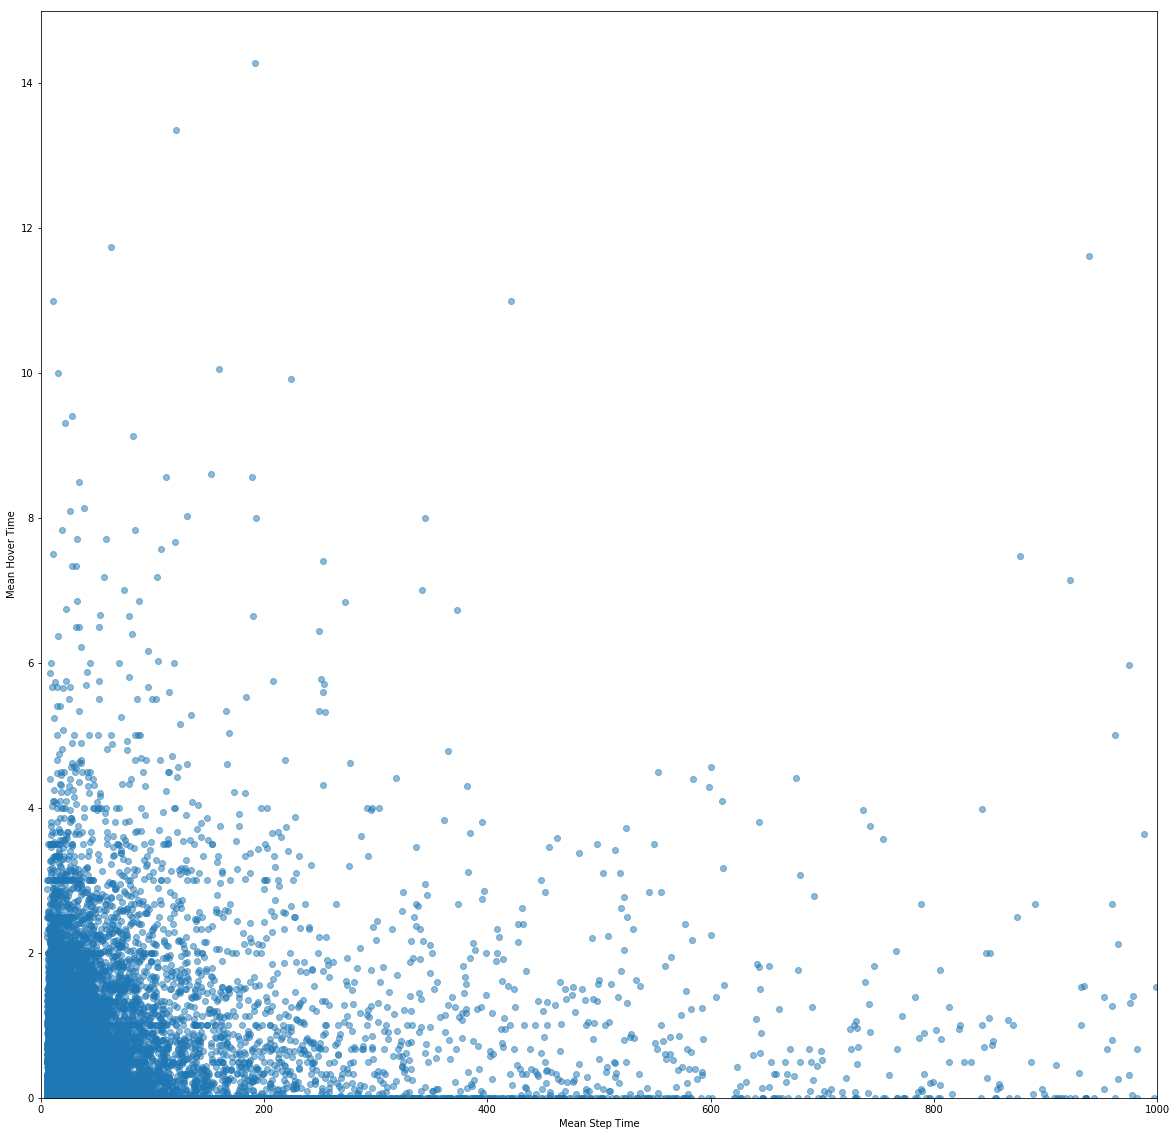

In [105]:
x = simplified_data["Mean Step Time"]
y = simplified_data["Mean Hover Time"]

plt.figure(figsize=(20,20))
plt.scatter(x, y, alpha = 0.5)
plt.ylabel('Mean Hover Time')
plt.xlabel('Mean Step Time')
plt.xlim(0, 1000)
plt.ylim(0, 15)
plt.show()

It seems as though there may be a weak, negative correlation between the mean hover time and the mean step time.  However, with so many data points so close to 0, even that seems like a stretch.  Maybe these variables aren't as related as we thought.

Let's take a look at how the distribution of data looks within each variable.

### Boxplots

Below are the boxplots for each variable.  These will allow us to look at each variable by itself and find where the data is centered and where the outliers are.  Unfortunately, these don't tell us too much about the data other than what we already know: that for each variable there is a high concentration around 0, with a large number of outliers.

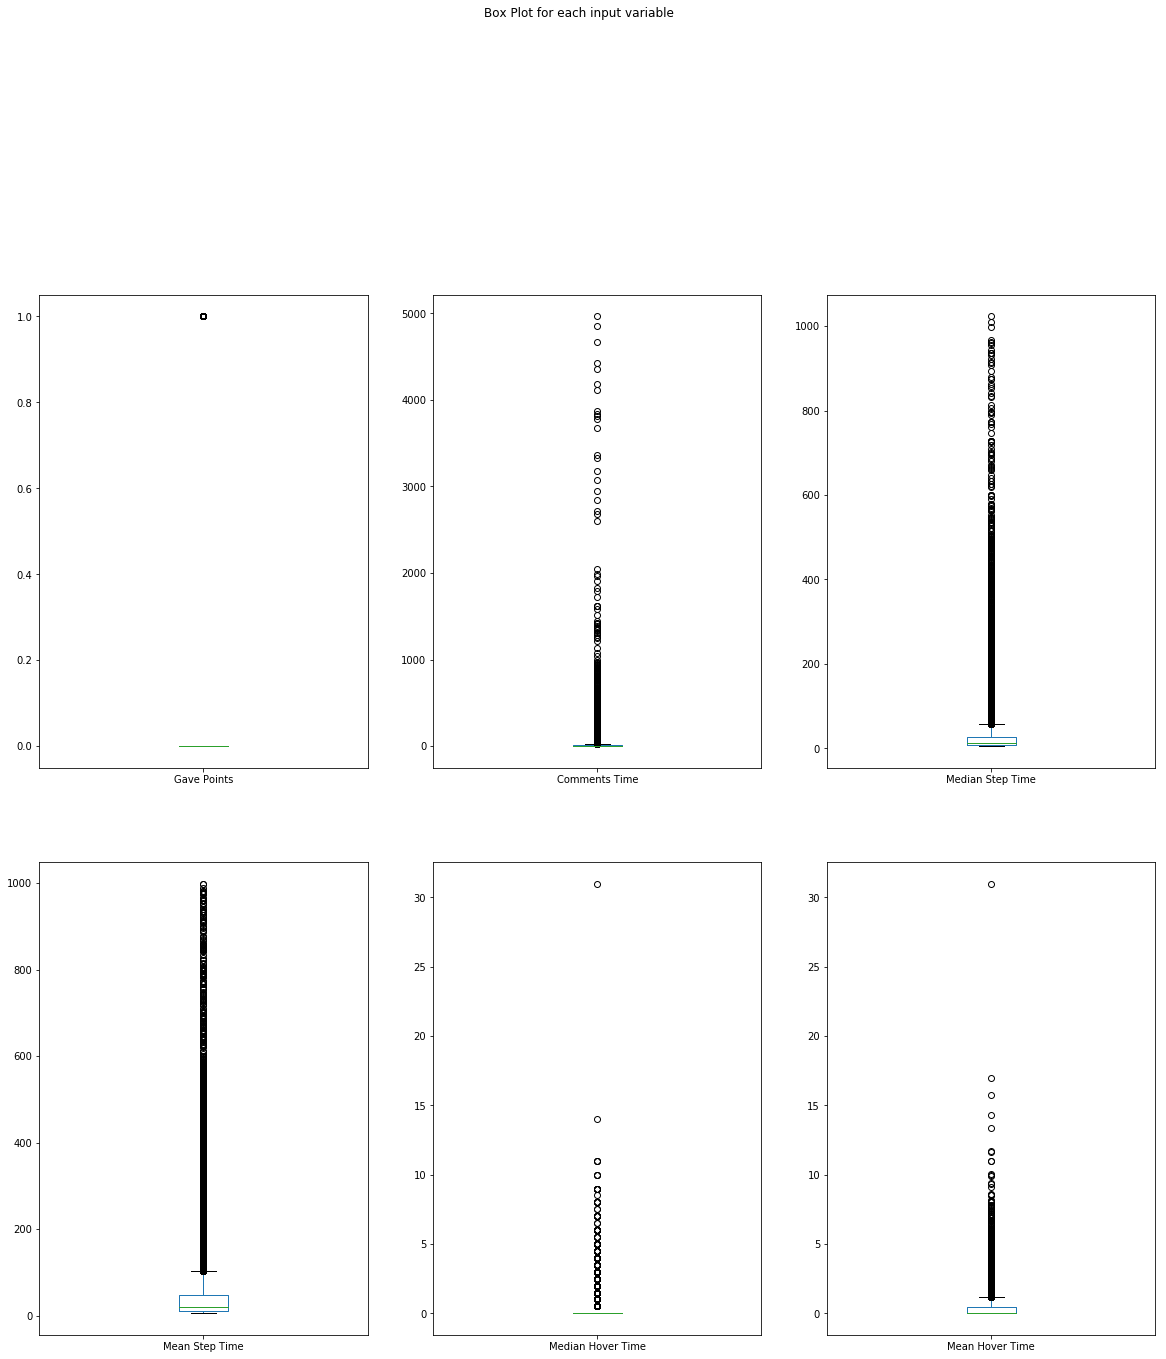

In [106]:
simplified_data.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False, figsize=(20,40), 
                                        title='Box Plot for each input variable')
plt.savefig('clean_box')
plt.show()

# Making Predictions Based on the Data

This data has a large range and extremely high variance, so it probably won't be a very good predictor of whether or not users are repairing.  Let's try anyway.

We will use an algorithm called k means clustering to split the data into a few groups.  This algorithm takes into account all of our variables and tries to group them into a set number of clusters.  We hope that these clusters will split the data into groups of users who are browsing and who are repairing.

In [6]:
# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans

# Declaring Model
model = KMeans(n_clusters=3)

# Fitting Model
model.fit(simplified_data.loc[:, :])

# Prediction on the entire data
all_predictions = model.predict(simplified_data.loc[:, :])

# Printing Predictions
#print(all_predictions)

x_axis = simplified_data.loc[:, "Mean Step Time"]  # Avg time spent viewing each step
y_axis = simplified_data.loc[:, "Mean Hover Time"]  # Avg num views per picture

data_clusters = simplified_data
data_clusters['Cluster'] = all_predictions

# Plotting
plt.figure(figsize=(15,15))
plt.scatter(x_axis, y_axis, c=all_predictions)
plt.ylabel('Mean Hover Time')
plt.xlabel('Mean Step Time')
plt.show()

NameError: name 'simplified_data' is not defined

Unfortunately, this is the best we can do.  Using this prediction we would expect the yellow data points to be repairs and the purple data points to be users just browsing the site.  However, this clearly seems like an oversimplification which doesn't accurately classify the data.

There are many reasons why we suspect we can't get a reliable classification based off of our data.  The most important reason is that this data reflects sessions across thousands of unique pages/guides on iFixit's website.  Each guide is unique.  The guides range in difficulty, number of steps, number of pictures, estimated repair time, and the number of comments.  It is difficult to classify users based on their behavior on the site as a whole when a user repairing a device on one page may look the exact same as a user simply browsing a different page.

#### Let's take a different approach.  Instead of trying to classify all the data at once, let's take a look at the data for a single repair guide.

#### Let's take a look at iFixit's most popular repair guide, iPhone 6 battery replacement

# iPhone 6 Battery Replacement

## Cleaning the Data

Since we are only looking at one guide, we don't have to filter our data as aggressively.  Let's start with our original data set and filter out all entries with mean and median step times of less than 1 second or greater than 5,000 seconds.  We will also continue to filter out entries where the amount of time spent reading comments was over 5,000 seconds.

Let's also take out the columns which we don't need for analyzing the data.  And, of course, we have to make sure to only include sessions where the user was viewing the iPhone 6 battery replacement guide.

This gives us 135 entries.

In [32]:
iPhones = data[(data['Mean Step Time'] > 1) & (data['Median Step Time'] > 1)]
iPhones = iPhones[(iPhones['Comments Time'] < 5000)]
iPhones = iPhones[(data['Mean Step Time'] < 5000)]

iPhones = iPhones[(iPhones['Page Title'].str.contains("/Guide/How\+to\+Replace\+Your\+iPhone\+6\+Battery/"))]

iPhones = iPhones.drop(columns = ['First Time', 'Last Time', 'Data Number', 'Page Title', 'Session ID'])

print(iPhones.shape)
iPhones.head()

(135, 6)


C:\Users\White Stallion\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Gave Points,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time
37,0.0,11.0,20.0,56.68,0.0,0.200000
128,0.0,356.0,60.0,977.64,0.0,0.033333
568,0.0,8.0,8.0,8.00,0.0,0.000000
1622,0.0,6.0,4.0,6.12,0.0,0.200000
2150,0.0,0.0,5.0,12.72,1.0,1.133333


## Data Visualization

Like we did with our large data set, let's take a more in-depth look at the iPhone 6 battery replacement data.  

### Boxplots
Let's start with some box plots.

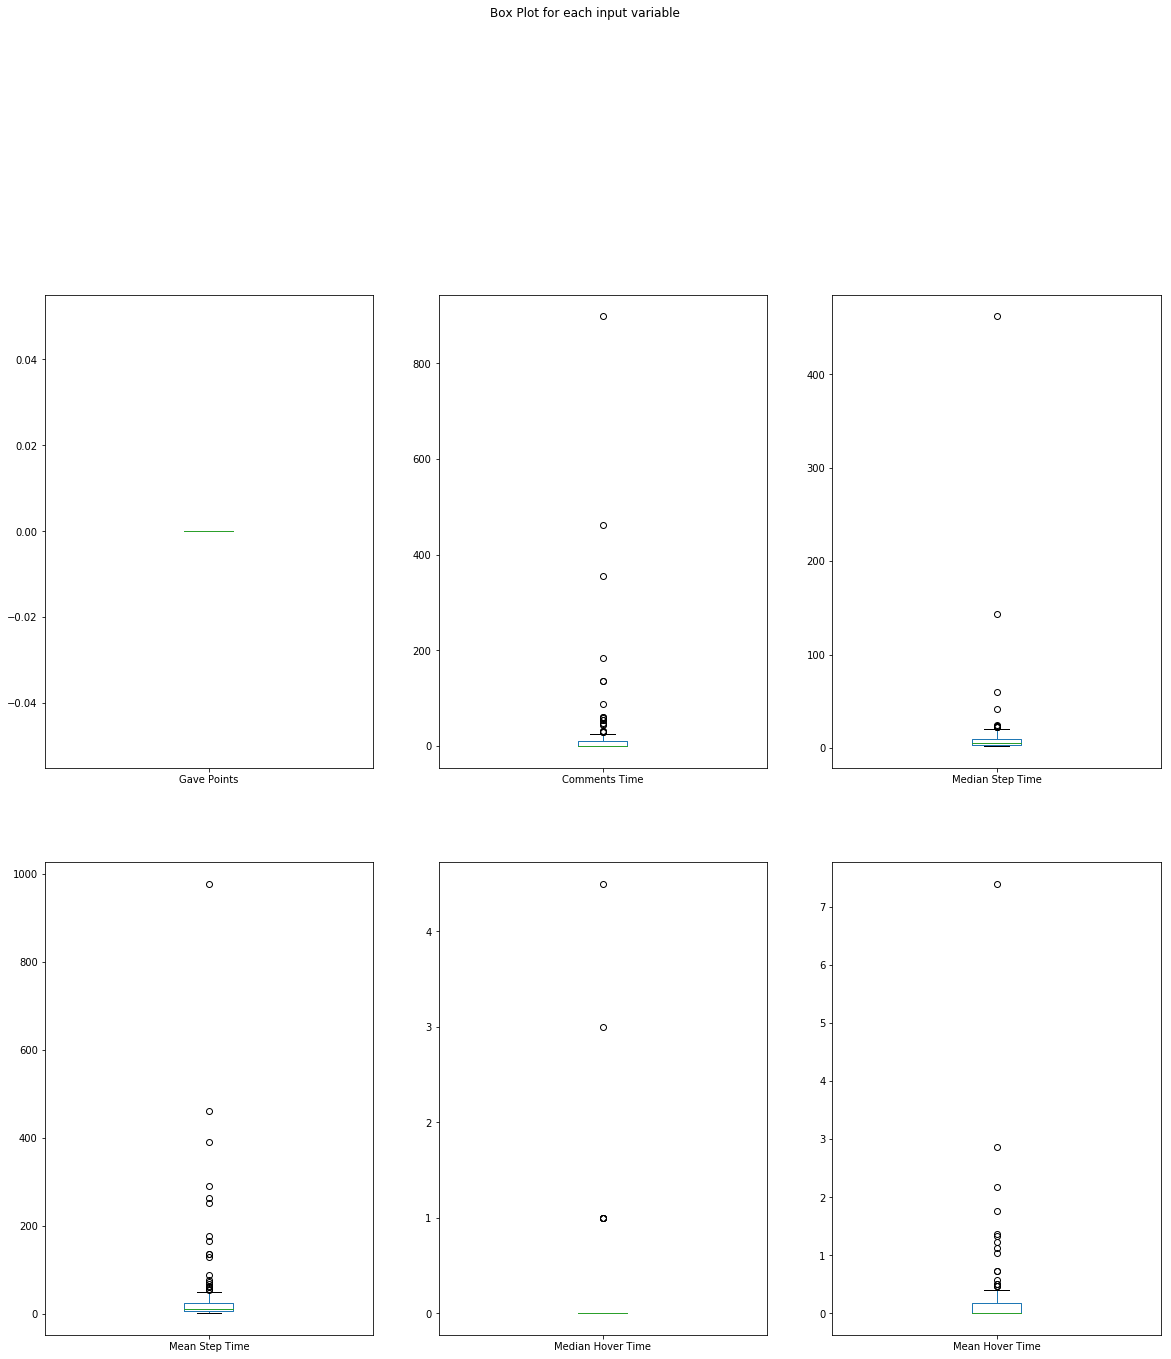

In [33]:
iPhones.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False, figsize=(20,40), 
                                        title='Box Plot for each input variable')
plt.show()

Similar to our large data set, these box plots are very helpful.  However, they show us that most variables have large clusters of data around 0, with outliers on the higher end.

One interesting thing to note is that none of the users represented by this data set clicked the 'Give the author points' button.

### Scatter Plot Matrix

Let's move on to a scatter plot matrix.  Since none of the users represented by this data set gave the author points, we can remove the 'Gave Points' column.

Text(0.5, 0.98, 'Scatter-matrix for each input variable')

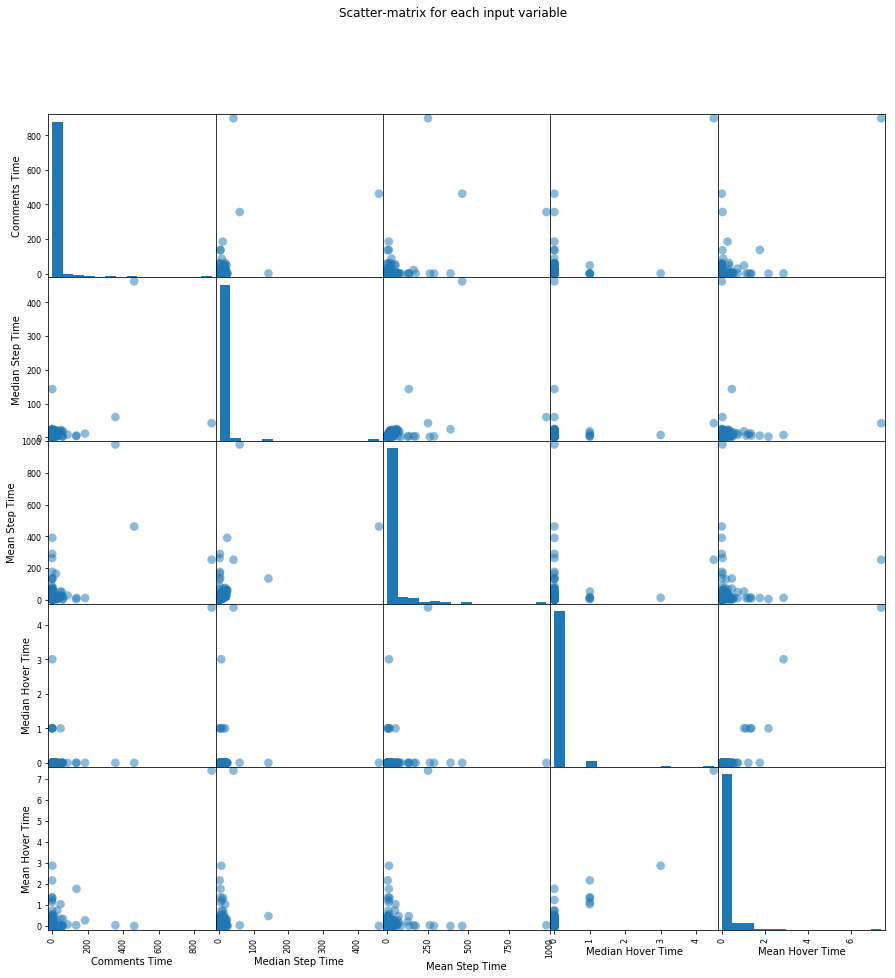

In [34]:
feature_names = ['Comments Time', 'Median Step Time', 'Mean Step Time', 'Median Hover Time', 'Mean Hover Time']
X = iPhones[feature_names]
scatter = pd.plotting.scatter_matrix(X, marker = 'o', s=75, hist_kwds={'bins':15}, figsize=(15,15))
plt.suptitle('Scatter-matrix for each input variable')

These scatter plots look much better than those representing the entire data set.  As we saw with the boxplots, there are still large concentrations of data points near 0 for each variable, but the rest of the data seems a bit more spread out, and the relationships between the mean and median step time/hover time seem more natural.  We don't see straight diagonal lines in our data anymore, which is a good thing.

### Histograms

Let's take a look at a few histograms.  These will help us to better see the distribution of data within each variable.  First, a histogram of the mean step time.

Text(0.5, 0, 'Mean Step Time')

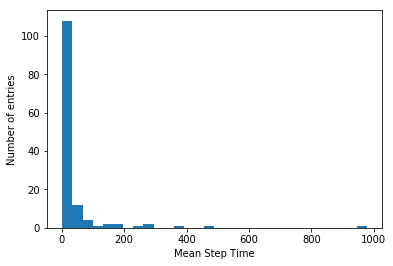

In [35]:
plt.hist(iPhones['Mean Step Time'], bins=30)
plt.ylabel('Number of entries')
plt.xlabel('Mean Step Time')

Let's zoom in a bit to see the cluster of data representing a mean step time from 0-100

(0, 100)

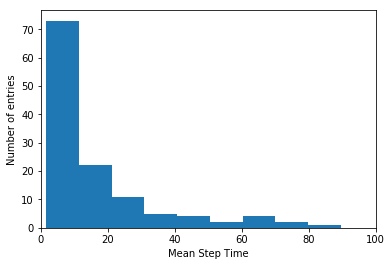

In [36]:
plt.hist(iPhones['Mean Step Time'], bins=100)
plt.ylabel('Number of entries')
plt.xlabel('Mean Step Time')
plt.xlim(0, 100)

These who histograms tell us more of what we already know, but in a bit more detail.  The majority of the data points have mean step times between 0 and 10, and the histogram is right-skewed.  There are large outliers in mean step time, with the furthest outlier having a mean step time of almost 1,000.

Let's check out the histograms for the amount of time reading comments.

(0, 100)

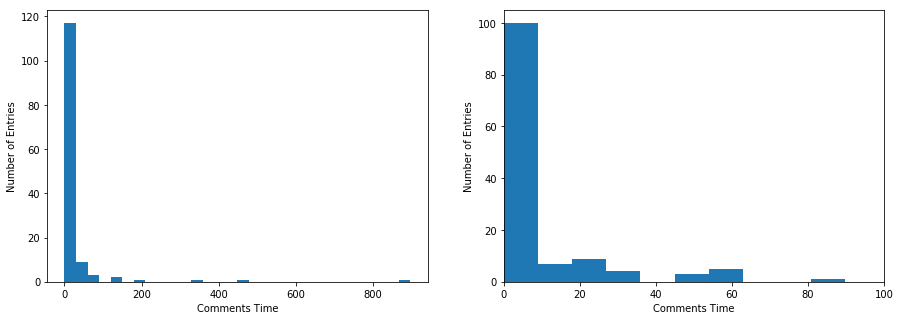

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(iPhones['Comments Time'], bins=30)
ax1.set_xlabel('Comments Time')
ax1.set_ylabel('Number of Entries')
ax2.hist(iPhones['Comments Time'], bins=100)
ax2.set_xlabel('Comments Time')
ax2.set_ylabel('Number of Entries')
ax2.set_xlim(0, 100)

These who histograms aren't much different than the ones for the mean step time.  The majority of the data points have between 0 and 10 seconds spent viewing comments.  This data is also right-skewed, with the furthest outlier at about 850 seconds.

And again for the mean time hovering over images.

(0, 1)

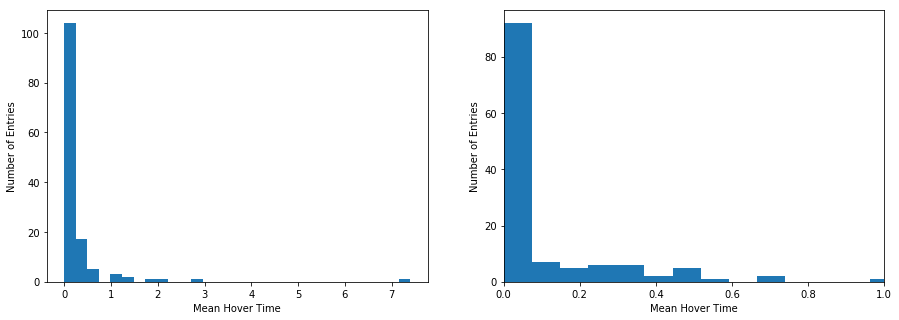

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(iPhones['Mean Hover Time'], bins=30)
ax1.set_xlabel('Mean Hover Time')
ax1.set_ylabel('Number of Entries')
ax2.hist(iPhones['Mean Hover Time'], bins=100)
ax2.set_xlabel('Mean Hover Time')
ax2.set_ylabel('Number of Entries')
ax2.set_xlim(0, 1)

More of the same.  The majority of data points have a hover time between 0 and 0.1.  The data is right-skewed, with the furthest outlier at about 7 seconds.

## Making Predictions

Let's try our classification again, this time on our iPhone 6 battery replacement data set.  We will use the same k means clustering algorithm to split the data into two groups.

C:\Users\White Stallion\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5, 0.98, 'Scatter-matrix for each input variable')

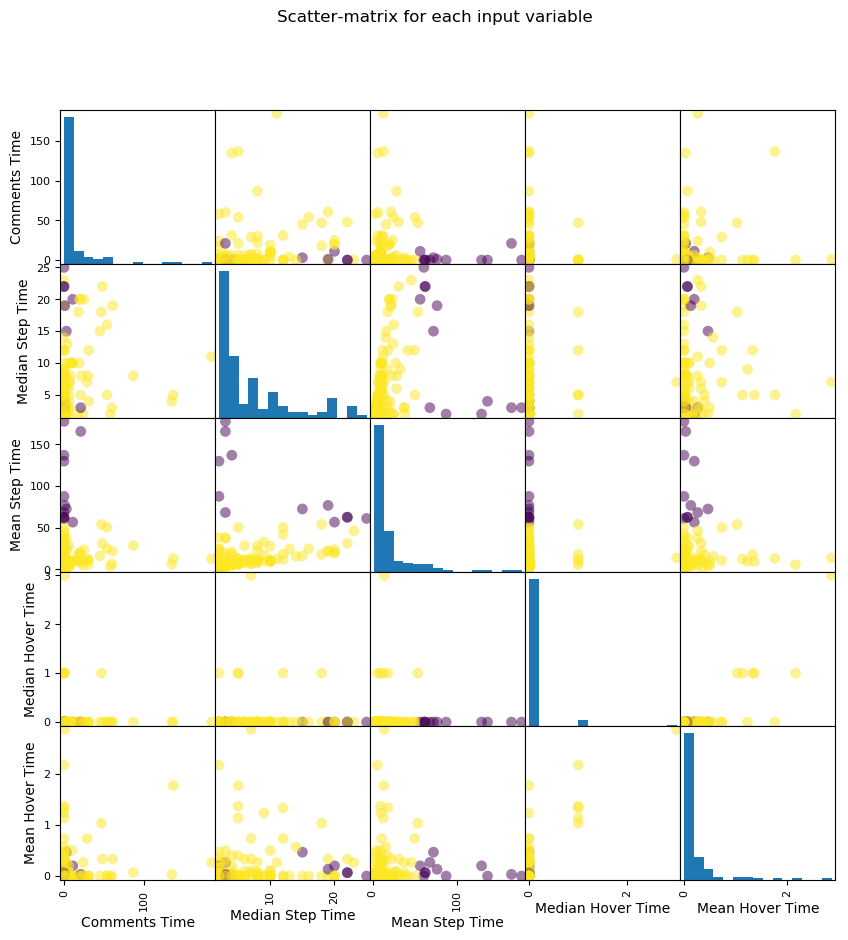

In [72]:
iPhone2 = iPhones[(iPhones['Mean Step Time'] < 200) & (iPhones['Median Step Time'] < 140)]

# Declaring Model
model = KMeans(n_clusters=2)

# Fitting Model
model.fit(iPhone2.loc[:, :])

# Prediction on the entire data
all_predictions = model.predict(iPhone2.loc[:, :])

# Printing Predictions
#print(all_predictions)

x_axis = iPhone2.loc[:, "Mean Step Time"]  # Avg time spent viewing each step
y_axis = iPhone2.loc[:, "Mean Hover Time"]  # Avg num views per picture

data_clusters = iPhone2
data_clusters['Cluster'] = all_predictions

#To switch the colors, to hold continuity with the graph below
for data in data_clusters['Cluster']:
    if data == 1:
        data = 0
    else:
        data = 1

# Plotting
plt.style.use('default')
feature_names = ['Comments Time', 'Median Step Time', 'Mean Step Time', 'Median Hover Time', 'Mean Hover Time']
X = data_clusters[feature_names]
scatter = pd.plotting.scatter_matrix(X, marker = 'o', s=60, c = data_clusters['Cluster'], hist_kwds={'bins':15}, figsize=(10,10))
plt.suptitle('Scatter-matrix for each input variable')

That looks much better.  K means clustering left us with two groups which look as expected.  The yellow cluster represents users who were just browsing, while the purple cluster represents users who were making repairs.

One thing that is important to note is that these data points have been split into two clusters based on all variables.  We have chosen to display them graphically in a scatter plot matrix because it allows us to see how they two clusters look across all 5 variables.  The grouping of the clusters seems to match our original assumptions that the amount of time spent on each step is likely the largest indicator of whether a user is repairing.

## Results

Here are the users which we have classified as those making repairs.

In [84]:
repairs = data_clusters[(data_clusters['Cluster'] == 0)]
repairs

,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time,Cluster
3752,0.0,13.5,166.333333,0.0,0.083333,0
5511,93.0,93.0,93.000000,0.0,0.000000,0
8787,99.0,99.0,99.000000,0.0,0.000000,0
34452,0.0,3.0,144.300000,0.0,0.979167,0
43825,0.0,38.0,123.733333,0.0,0.791667,0
60505,0.0,67.5,166.333333,1.0,1.145833,0
64320,0.0,118.0,241.566667,0.0,0.333333,0
78069,380.0,85.5,165.133333,0.5,1.375000,0
98504,0.0,20.0,218.700000,0.0,0.437500,0
107846,0.0,61.5,161.133333,0.0,0.854167,0


## Verification

Unfortunately, we don't have any verification data.  That is, we don't have any data which we are sure represents either a user actively engaging in a repair or simply browsing the page.  If we did have this data, we would be able to test how accurate our model is, which would allow us to tweak it to improve accuracy.

The best we can do with the data we have is to ask: does this make sense?  Furthermore, does it seem likely that all repairs were accurately classified as such, and that no browsing users were incorrectly classified as repairing users (did we avoid both type 1 and type 2 errors)?

The best we can do to answer these questions without verification data is to look at the amount of time users were on the page and compare that to the amount of time it should take them to do the repair.  Fortunately, iFixit lists the estimated repair time on the top of each of their guides.  For this particular guide, iFixit's estimated repair time is 15-45 minutes.

When looking at the cluster of data classified as repairs, we see that the lowest mean step time is about 55 seconds.  Since this guide has 25 steps in it, that means the user spent 1,375 seconds looking at this page, which translates to about 23 minutes.  On the other end of the data, the highest mean step time is about 175 seconds.  This user spent 4,375 seconds looking at this page, or 73 minutes.

So, the users we classified as those actively repairing their devices spent between 23-73 minutes on this particular guide where the estimated time to repair was 15-45 minutes.  ((However, we have to keep in mind that most users who repair their devices probably put them back together while spend time putting them back together.)) This result is not perfect, and it seems possible that we may have both type 1 and type 2 errors.  However, this result seems "good enough", especially given the small amount of data and the lack of verification data.  While the data points we have classified as repairs may not be a reliable indication of which users are repairing, we believe that the mixture of type 1 and type 2 errors still give a relatively accurate indication of *how many* users are repairing.

## One More Classification

To see if this method of classifying repairs is reliable, let's try it again on another popular repair.  This time we will look at the iPhone 6 screen repair guide.

Since we are only interested in the classification for this page, let's skip all the intermittent data visualization.

In [81]:
screen_repair = data[(data['Mean Step Time'] > 1) & (data['Median Step Time'] > 1)]
screen_repair = screen_repair[(screen_repair['Comments Time'] < 400)]
screen_repair = screen_repair[(screen_repair['Mean Step Time'] < 350) & (screen_repair['Median Step Time'] < 200)]

screen_repair = screen_repair[(screen_repair['Page Title'].str.contains("Guide/iPhone\+6s\+Screen\+Replacement"))]

screen_repair = screen_repair.drop(columns = ['First Time', 'Last Time', 'Data Number', 'Page Title', 'Session ID'])

print(screen_repair.shape)
screen_repair.head()

(78, 6)


,Gave Points,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time
3611,0.0,0.0,1.5,2.333333,0.0,0.291667
3752,0.0,0.0,13.5,166.333333,0.0,0.083333
5511,0.0,93.0,93.0,93.000000,0.0,0.000000
7230,0.0,0.0,2.0,12.400000,0.0,0.687500
7918,0.0,0.0,3.0,105.766667,0.0,0.312500


Text(0.5, 0.98, 'Scatter-matrix for each input variable')

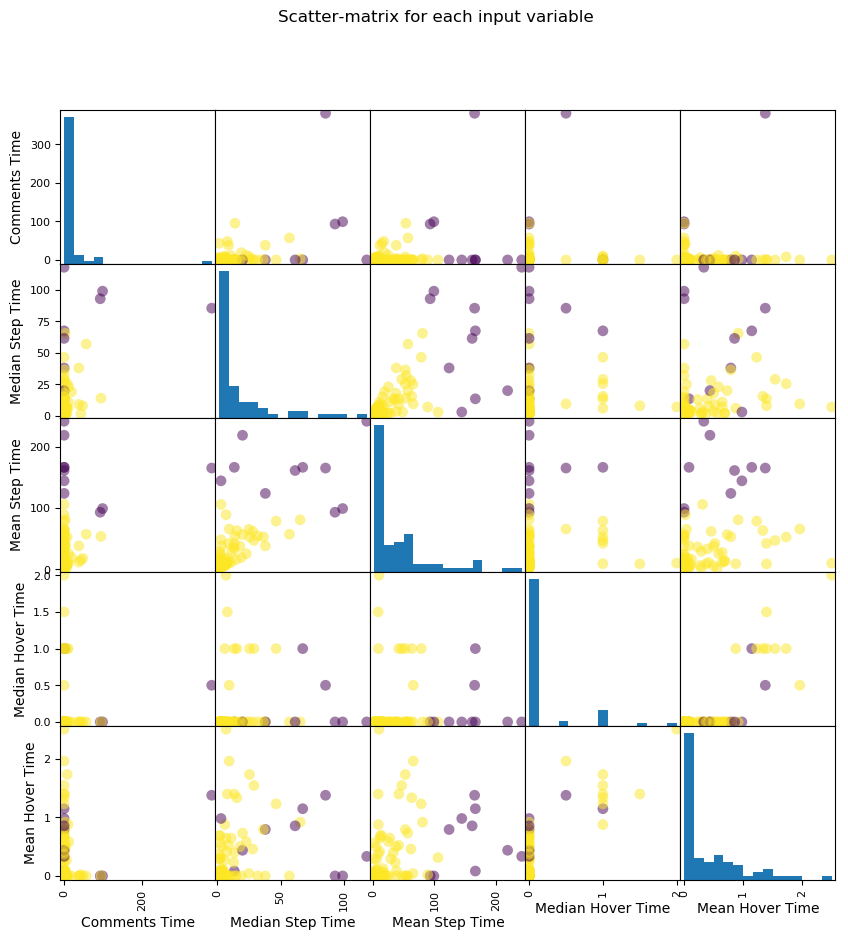

In [82]:
# Declaring Model
model = KMeans(n_clusters=2)

# Fitting Model
model.fit(screen_repair2.loc[:, :])

# Prediction on the entire data
all_predictions = model.predict(screen_repair2.loc[:, :])

x_axis = screen_repair2.loc[:, "Mean Step Time"]  # Avg time spent viewing each step
y_axis = screen_repair2.loc[:, "Mean Hover Time"]  # Avg num views per picture

data_clusters = screen_repair2
data_clusters['Cluster'] = all_predictions

# Plotting
feature_names = ['Comments Time', 'Median Step Time', 'Mean Step Time', 'Median Hover Time', 'Mean Hover Time']
X = data_clusters[feature_names]
scatter = pd.plotting.scatter_matrix(X, marker = 'o', s=60, c = data_clusters['Cluster'], hist_kwds={'bins':15}, figsize=(10,10))
plt.suptitle('Scatter-matrix for each input variable')

Viola!  The clusters here look similar to those in the previous example; mean step time seems to be the biggest indicator of how a data point is clustered.  The one big difference in this classification is that the data points with the highest 'Comments Time' have been classified as repairs.

## Results

Here are the users which were classified as those repairing their iPhone 6 screens.

In [83]:
repairs = data_clusters[(data_clusters['Cluster'] == 0)]
repairs

,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time,Cluster
3752,0.0,13.5,166.333333,0.0,0.083333,0
5511,93.0,93.0,93.000000,0.0,0.000000,0
8787,99.0,99.0,99.000000,0.0,0.000000,0
34452,0.0,3.0,144.300000,0.0,0.979167,0
43825,0.0,38.0,123.733333,0.0,0.791667,0
60505,0.0,67.5,166.333333,1.0,1.145833,0
64320,0.0,118.0,241.566667,0.0,0.333333,0
78069,380.0,85.5,165.133333,0.5,1.375000,0
98504,0.0,20.0,218.700000,0.0,0.437500,0
107846,0.0,61.5,161.133333,0.0,0.854167,0


After looking at this data, there are two data points that seem out of place.  The second and third entries (SIDs 5511 and 8787) look strage.  Both entries have identical 'Comments Time', 'Median Step Time', and 'Mean Step Time', and they both have 0 'Median Hover Time' and 'Mean Hover Time'.  It seems almost impossible that one data point would look this way, let alone two of them.  Although it's not clear how or why these data points look the way they do, it *does* seem clear that they are probably instances of bad data.  Let's remove them and see how our results look.

In [92]:
repairs = repairs.drop([5511, 8787])
repairs

,Comments Time,Median Step Time,Mean Step Time,Median Hover Time,Mean Hover Time,Cluster
3752,0.0,13.5,166.333333,0.0,0.083333,0
34452,0.0,3.0,144.300000,0.0,0.979167,0
43825,0.0,38.0,123.733333,0.0,0.791667,0
60505,0.0,67.5,166.333333,1.0,1.145833,0
64320,0.0,118.0,241.566667,0.0,0.333333,0
78069,380.0,85.5,165.133333,0.5,1.375000,0
98504,0.0,20.0,218.700000,0.0,0.437500,0
107846,0.0,61.5,161.133333,0.0,0.854167,0


## Verification

Like we mentioned previously, we don't have a very good way of verifying our results.  The best we can do is to compare the estimated repair time to the range of repair times found in our data.

For this particular guide, the estimated repair time is 30-60 minutes.  There are 30 steps in this guide.  Our fastest repairer had a mean step time of about 124 seconds.  It took them 3,720 seconds across all steps, or 62 minutes.  Our slowest repairer had a mean step time of about 242 seconds, which translates to a total repair time of 121 minutes.  Unfortunately, this result seems to be less accurate than our last one.  But, like we said earlier, it is hard to verify these results without any real verification data.

# Conclusion

Classifying users into two groups based on whether they are browsing or repairing proved to be more difficult than we expected.  There were a few reasons for this.  

First of all, it is very difficult to classify user behavior across the entire iFixit website.  Since each repair guide is different, it seems impossible to classify users based only on the data we collected.  If we had any hope of classifying users on the site as a whole, we would have needed to collect data about the guide each user was looking at, such as the difficulty, the number of steps, and the estimated repair time.  It was hard to determine what data would be useful to us until we actually started looking at our data and using it to make a classification.  Now that we have worked with the data, it seems obvious to us that these metrics are essential in classifying users site-wide.

Second, it is hard to identify and filter out bad data.  We did our best to clean up the data and use only that which seemed reliable.  But, even then, we were making decisions on what *seemed* best or what *seemed* reliable.  It seems unlikely that a user would spend 4-6 hours repairing a device, so we generally tossed out those data points.  But what if that *was* a real user repairing their device?  Maybe they aren't very tech savvy and this is their first time repairing, or maybe they took long breaks in the middle or did the repair over the course of a few hours while doing other things.  Or, on the other hand, maybe that data point really was caused by a error in data collection.  It's hard to know for sure.  Even when making a classification at the end of this report (just a few cells up), after working with the same data set for days, we found two data points which almost certainly were not reliable.  The k means clustering algorithm that we used to classify the data can only be as reliable as the data you give it.  While we are confident that we filtered out most of the bad data, we can't guarantee that no bad data still exists.

Finally, and most importantly, we don't have any verification data.  We are somewhat confident in our classification of users in the two iPhone guides we looked at, but there is no way to know for sure.  The verification method we used was the best we could come up with, but we would have liked to do much better.  If we had 5 to 10 data points for each guide which we knew were either simple browsing or active repairs, we would have a much better idea of how accurate our models are, and we could have tweaked these models in order to improve accuracy.


If we were to repeat this process we would do a few things differently.  First, we would spend some more time testing our data collection script to ensure that the data we receive from it is reliable.  Second, we would collect additional data for each session: the difficulty rating of the guide, the number of steps in the guide, and the estimated completion time of the repair.  Third, we would make sure to obtain reliable verification data for a few popular repair guides in order to test the validity of our models.  If we found these specific models to be reliable, then it *might* be possible to create a model to classify behavior across the entire site.